In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [19]:
df = pd.read_csv("assignment2dataset.csv")

In [20]:
#df.describe()

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


In [22]:
#df.iloc[:, 2:3].value_counts()

Extracurricular Activities
No                            5052
Yes                           4948
dtype: int64

In [23]:
ohe = OneHotEncoder() 
encoded = pd.DataFrame(ohe.fit_transform(df[['Extracurricular Activities']]).toarray())
encoded.set_axis(['Extracurricular-NO', 'Extracurricular-YES'], axis='columns', inplace=True)
df = df.join(encoded)
#df

In [24]:
df.drop(labels=['Extracurricular Activities', 'Extracurricular-NO'], axis=1, inplace=True)

In [25]:
df.corr()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index,Extracurricular-YES
Hours Studied,1.000000,-0.012390,0.001245,0.017463,0.373730,0.003873
Previous Scores,-0.012390,1.000000,0.005944,0.007888,0.915189,0.008369
Sleep Hours,0.001245,0.005944,1.000000,0.003990,0.048106,-0.023284
Sample Question Papers Practiced,0.017463,0.007888,0.003990,1.000000,0.043268,0.013103
Performance Index,0.373730,0.915189,0.048106,0.043268,1.000000,0.024525
Extracurricular-YES,0.003873,0.008369,-0.023284,0.013103,0.024525,1.000000


<AxesSubplot:>

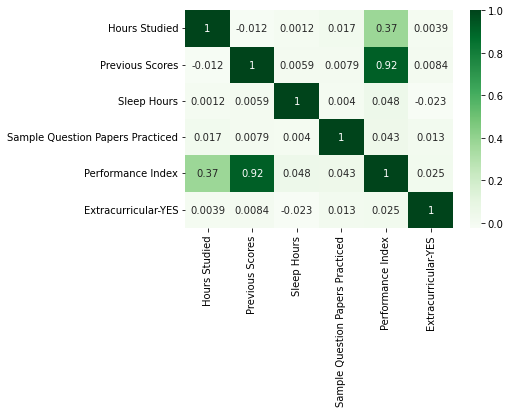

In [26]:
#plotting correlation matrix 
sns.heatmap(df.corr(), cmap="Greens", annot=True)

Since Extracurricular Activities is originally categorical, a better way to find its correlation with 'Performance Index' would be by Point-Biserial Correlation. It is a test that is suitable for exploring the relationship between a single binary variable (Extracurricular Activities) and a continuos variable(Performance Index).

In [27]:
from scipy import stats

extracurricular_activities = df["Extracurricular-YES"]
performance_index = df["Performance Index"]

# Calculate the point-biserial correlation coefficient
point_biserial_corr, p_value = stats.pointbiserialr(extracurricular_activities, performance_index)

# Print the correlation coefficient and p-value
print("Point-Biserial Correlation:", point_biserial_corr)
print("p-value:", p_value)

Point-Biserial Correlation: 0.024524946967550535
p-value: 0.014184491568632522


In [28]:
#df.columns

In [29]:
df_short = df.copy()
df_short.columns = ['Hrs', 'Scores', 'Sleep', 'Ques', 'Performance', 'Yes']

#df_short

In [30]:
X = df_short[['Scores', 'Hrs']]
Y = df_short[['Performance']]

In [31]:
def polynomial_fts(X,degree):
   
    """idea: for degree 1, the features are the same as input X
    for each degree, we multiply each column in X with the dataframe resulting from the previous degree, 
    but only take columns which are non-repeated. 
    for example, if X.columns = [a,b,c] then for degree 1 the resulting df would have columns [a,b,c]
    for degree 2, we multiply each of X.columns with the resulting matrix from degree 1
    [a,b,c]*a -> aa,ab,ac
    [a,b,c]*b -> ab,bb,bc
    [a,b,c]*c -> ac,bc,cc
    by observing the pattern we can see that for every col, the multiplications before col*i are redundant"""
    
    poly_fts = X.copy()
    tmp_df = X.copy()     

    for i in range(2, degree + 1):
        #create new 'degree' list to which the rest will be compared
        current_df = pd.DataFrame()
        start = False

        for c in X:
            #reset boolean for each col 
            start = False
            for col in tmp_df:
                col_name = f"{c}{col}"
                
                if(col_name == c*i):
                    start = True
                
                if(start==True):                    
                    #calc new feature 
                    new_feature = tmp_df.loc[:, col] * X.loc[:, c] 

                    #add new feature to dataframe that will be returned
                    poly_fts[col_name] = new_feature
                    
                    #add to 'degree' list 
                    current_df[col_name] = new_feature

        tmp_df = current_df
    
    #adding the bias column to the beginning of the dataframe
    first_col = np.ones(X.shape[0]).tolist()
    poly_fts.insert(loc=0, column = "bias", value=first_col)
    return poly_fts

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2,shuffle=True, random_state = 16)


In [33]:
def mse(deg):
    for i in range(deg):
        print("\ndegree: ", i)
        ftsTrain = polynomial_fts(X_train, i)
        ftsTest = polynomial_fts(X_test, i)

        # Create linear regression object
        regr = linear_model.LinearRegression()

        # Train the model using the training sets
        regr.fit(ftsTrain, Y_train)

        # Make predictions using the training set
        y_pred_train = regr.predict(ftsTrain)

        # Make predictions using the testing set
        y_pred_test = regr.predict(ftsTest)

        # The coefficients
        #print("Coefficients: \n", regr.coef_)
        #print("Intercept: ", regr.intercept_)
        # The mean squared error
        print("Mean squared error of train is: ", mean_squared_error(Y_train, y_pred_train))
        print("Mean squared error of test is: ", mean_squared_error(Y_test, y_pred_test))
        
    

In [34]:
'''To choose the best degree, we can loop over a sample of degrees (for example the first 10), and choose the 
degree with the least test error before it starts increasing again (indicating overfitting)'''
mse(10)


degree:  0
Mean squared error of train is:  5.212426808419098
Mean squared error of test is:  5.224550798634713

degree:  1
Mean squared error of train is:  5.212426808419098
Mean squared error of test is:  5.224550798634713

degree:  2
Mean squared error of train is:  5.210520510694536
Mean squared error of test is:  5.222238216663904

degree:  3
Mean squared error of train is:  5.207130498804473
Mean squared error of test is:  5.219381091617662

degree:  4
Mean squared error of train is:  5.203950816667608
Mean squared error of test is:  5.216415116346207

degree:  5
Mean squared error of train is:  5.197112763354189
Mean squared error of test is:  5.240598830728179

degree:  6
Mean squared error of train is:  5.191445396642641
Mean squared error of test is:  5.247260444534401

degree:  7
Mean squared error of train is:  5.190147482716535
Mean squared error of test is:  5.24542337286627

degree:  8
Mean squared error of train is:  5.190918762650586
Mean squared error of test is:  5.